In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Import Library

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 


In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Import the data 

In [4]:
# Load the data using Keras Image genarator 
img_gen = ImageDataGenerator(rescale=1./255) # assign a image generator

training_set = img_gen.flow_from_directory(directory='../input/cat-and-dog/training_set/training_set', target_size=(224,224), 
                                           classes=['cats', 'dogs'], batch_size=10)


Found 8005 images belonging to 2 classes.


In [5]:
test_set = img_gen.flow_from_directory(directory= '../input/cat-and-dog/test_set/test_set', target_size=(224,224), classes=['cats', 'dogs'], 
                                       batch_size=10, shuffle=False)

Found 2023 images belonging to 2 classes.


# Visualize the Data

In [6]:
imgs, labels = next(training_set)
# note size of batch is determine when we create a train set

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

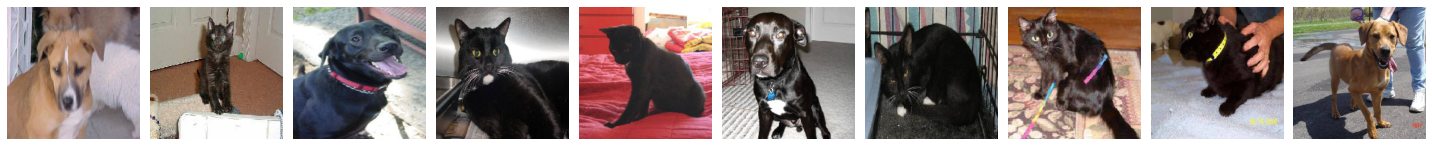

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [8]:
plotImages(imgs)
print(labels)
# So here 1. 0. represent cat and 0. 1. represent Dog 
# So here already one hot encoding is done 

# Build an CNN 

In [9]:
# 1st import the model from tensorflow 
from tensorflow.keras.models import Sequential

cnn = Sequential()

# Import the layers From tensorFlow
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout

# 1st Convolution and Pooling layers
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2),)

# 2nd Convolution and Pooling layers
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2),)

# Flatten the layers so that we pass this to dense layers
cnn.add(Flatten())

# output layers
cnn.add(Dense(units=2, activation='softmax'))



note that the input shape is always same as terget size
 
here we select default parameter for Polling layers

the output layer has 2 nodes, one for cat and one for dog.the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.

# Traing the model CNN 

In [10]:
# 1st we have to compile the model 
from tensorflow.keras.optimizers import Adam
cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  ####

We use categorical crossentropy because here is 2 neuron in output layers or the out put layers have two output
and use Adam optimizer for socrates gradient descent

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [12]:
# Add early stopping if overfitting happen then apply 
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

Early Stopping used to avoid over fitting and also by early stoping we get an idea about number of epoch required to fit the model 

In [13]:
# now fit the model 
cnn.fit(x=training_set, epochs=15,validation_data=test_set, callbacks=[early_stop])

Epoch 1/15
801/801 [==============================] - 106s 124ms/step - loss: 0.6679 - accuracy: 0.5876 - val_loss: 0.5790 - val_accuracy: 0.7044
Epoch 2/15
801/801 [==============================] - 39s 48ms/step - loss: 0.5220 - accuracy: 0.7475 - val_loss: 0.5393 - val_accuracy: 0.7341
Epoch 3/15
801/801 [==============================] - 38s 47ms/step - loss: 0.4465 - accuracy: 0.7932 - val_loss: 0.5411 - val_accuracy: 0.7336
Epoch 4/15
801/801 [==============================] - 38s 48ms/step - loss: 0.3839 - accuracy: 0.8432 - val_loss: 0.5281 - val_accuracy: 0.7395
Epoch 5/15
801/801 [==============================] - 38s 47ms/step - loss: 0.3267 - accuracy: 0.8703 - val_loss: 0.6001 - val_accuracy: 0.7128
Epoch 6/15
801/801 [==============================] - 39s 49ms/step - loss: 0.2903 - accuracy: 0.8856 - val_loss: 0.5619 - val_accuracy: 0.7341


# Evaluate the model

We see that without using early stopping led us to overfitting so we have to use early stopping 

In [14]:
losses = pd.DataFrame(cnn.history.history) # Using the early stoping 

<AxesSubplot:>

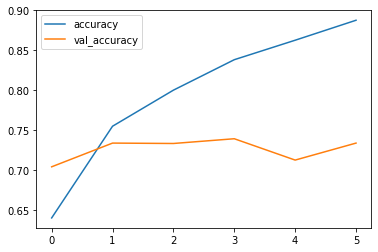

In [15]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

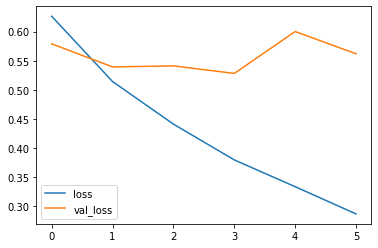

In [16]:
losses[['loss','val_loss']].plot()


In [17]:
# Save the model so that we can use later 
cnn.save('my_model.h5')
!ls

__notebook_source__.ipynb  my_model.h5


### Create clasification report and confusion matrix

In [18]:
y_pred = cnn.predict(x=test_set, verbose=0)

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

[[815 196]
 [342 670]]


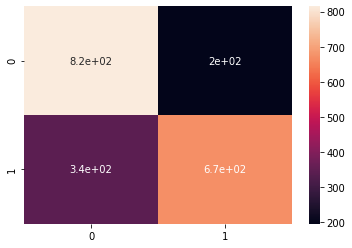

In [28]:
cm = confusion_matrix(y_true=test_set.classes, y_pred=np.argmax(y_pred, axis=-1))
sns.heatmap(cm,annot=True)
print(cm)

In [26]:
report = classification_report(y_true=test_set.classes, y_pred=np.argmax(y_pred, axis=-1))
print(report)

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1011
           1       0.77      0.66      0.71      1012

    accuracy                           0.73      2023
   macro avg       0.74      0.73      0.73      2023
weighted avg       0.74      0.73      0.73      2023



So our overall accuracy is 73 percent and f1 score is 75 percent on cat so model will predict better cat images 

# Predicting with Test image

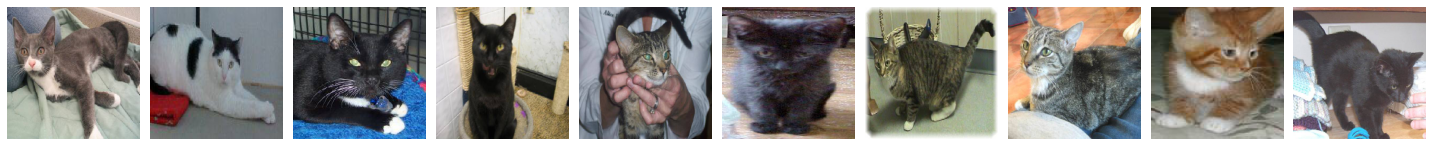

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [32]:
test_img, test_label = next(test_set)

plotImages(test_img)
print(test_label)

In [33]:
img_pred = cnn.predict(test_img)

In [35]:
np.round(img_pred) # img predict by the model 

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

So Here it predict 8 image correct from 10 images from test batch 

### Predict image from data directory

dog




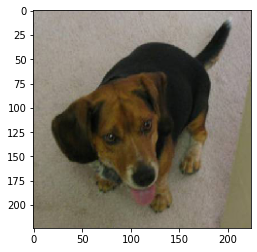

In [48]:
dat = '../input/cat-and-dog/test_set/test_set/cats/cat.4005.jpg'
dat2 = '../input/cat-and-dog/test_set/test_set/dogs/dog.4020.jpg'
test_image1 = image.load_img(dat2, target_size = (224, 224)) # Change when directory change 

import numpy as np
from keras.preprocessing import image
test_image = image.load_img(dat2, target_size = (224, 224)) # Change when directory change 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'cat'
else:
  prediction = 'dog'

print(prediction)
print('\n')
plt.imshow(test_image1)

# Thats All!